# SARIMAX Forecast of Arctic Sea Ice Area  

### Libraries Imported
- **pandas** & **numpy**: for data handling and numerical operations  
- **matplotlib**: for plotting time series and forecast results  
- **pathlib.Path**: for managing file paths  
- **statsmodels.tsa.statespace.sarimax.SARIMAX**: for building and forecasting with the SARIMAX model  


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Step 1: Load and Prepare Arctic Sea Ice Data
- **Load dataset**: Reads the processed Arctic dataset (`final_arctic.csv`).  
- **Sort data**: Orders records by `year` and `month`.  
- **Create PeriodIndex**: Converts year-month into a proper monthly time index (`date`).  
- **Define variables**:  
  - `y`: Target variable → Sea Ice Area (million km²).  
  - `X_exog`: Exogenous predictors → all other variables, cleaned by handling infinities and filling missing values.  

In [10]:
# Load Data
BASE_DIR = Path().resolve().parents[1]
file_PATH_arctic = BASE_DIR / "data" / "final" / "final_arctic.csv"
df = pd.read_csv(file_PATH_arctic)
df = df.sort_values(["year", "month"])

# Use PeriodIndex for monthly data
df["date"] = pd.PeriodIndex(year=df["year"], month=df["month"], freq="M")

# Target & exogenous features
y = df["sia_million_km2"]
X_exog = df.drop(columns=["sia_million_km2", "year", "month", "date"]) \
           .replace([np.inf, -np.inf], np.nan).ffill().bfill()

C:\Users\Sumukh D S\AppData\Local\Temp\ipykernel_25268\3968065185.py:8: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  df["date"] = pd.PeriodIndex(year=df["year"], month=df["month"], freq="M")


### Step 2: Train SARIMAX Model
- **Model choice**: A SARIMAX model is fitted to capture seasonality and trend in Arctic sea ice.  
- **Configuration**:  
  - `order=(0,1,0)`: First differencing to remove trend.  
  - `seasonal_order=(2,2,0,12)`: Seasonal differencing with 12-month cycle, allowing for seasonal persistence.  
  - `exog=X_exog`: Includes external predictors (e.g., climate drivers).  
- **Fit**: Model is trained (`fit`) without verbose output (`disp=False`).  

In [11]:
# Train SARIMAX
sarimax_model = SARIMAX(y, exog=X_exog,
                        order=(0, 1, 0), seasonal_order=(2, 2, 0, 12))
sarimax_res = sarimax_model.fit(disp=False)

c:\Users\Sumukh D S\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Step 3: Forecast with SARIMAX
- **Forecast horizon**: 25 years ahead (`n_years_forecast=25`), monthly steps.  
- **Future exogenous predictors**:  
  - Extended using the last 12 months of observed `X_exog`, repeated forward.  
  - Ensures external variables are aligned with forecast steps.  
- **Forecast generation**:  
  - `get_forecast()` produces predicted mean and 95% confidence intervals.  
- **Result formatting**:  
  - `forecast_df` contains timestamped predictions with year & month extracted for easy plotting or analysis.  

In [12]:
# Forecast
n_years_forecast = 25
future_periods = pd.period_range(start=df["date"].iloc[-1] + 1, periods=n_years_forecast * 12, freq="M")
future_exog = pd.DataFrame(
    np.tile(X_exog.iloc[-12:].values, (n_years_forecast, 1)),
    columns=X_exog.columns
)
forecast = sarimax_res.get_forecast(steps=len(future_periods), exog=future_exog)
forecast_ci = forecast.conf_int(alpha=0.05)
forecast_df = pd.DataFrame({
    "date": future_periods.to_timestamp(),
    "forecast": forecast.predicted_mean,
    "lower_95": forecast_ci.iloc[:, 0],
    "upper_95": forecast_ci.iloc[:, 1]
})
forecast_df["year"] = forecast_df["date"].dt.year
forecast_df["month"] = forecast_df["date"].dt.month

### Step 4: 2024 Forecast Extraction
- **Annual average (2024)**  
  - Computes the mean of monthly forecasts for 2024.  
  - Gives a single representative figure for the year.  

- **Monthly breakdown (2024)**  
  - Filters `forecast_df` for rows where `year == 2024`.  
  - Extracts forecast, lower CI, and upper CI for each month.  
  - Prints a clean table with month-by-month predictions and 95% confidence intervals.  

In [13]:
# 2024 Predictions
avg_2024 = forecast_df.loc[forecast_df["year"] == 2024, "forecast"].mean()
print(f"\nAverage Sea Ice Area in 2024 (forecast): {avg_2024:.3f} million km²")

print("\nMonthly Forecast for 2024 with 95% CI:")
forecast_2024 = forecast_df[forecast_df["year"] == 2024][
    ["year", "month", "forecast", "lower_95", "upper_95"]
].reset_index(drop=True)
print(forecast_2024.to_string(index=False))


Average Sea Ice Area in 2024 (forecast): 9.471 million km²

Monthly Forecast for 2024 with 95% CI:
 year  month  forecast  lower_95  upper_95
 2024      1 12.498493 12.239222 12.757763
 2024      2 13.402788 13.036125 13.769452
 2024      3 13.582822 13.133752 14.031891
 2024      4 13.011905 12.493365 13.530446
 2024      5 11.658943 11.079197 12.238690
 2024      6  9.294590  8.659509  9.929670
 2024      7  6.727863  6.041898  7.413828
 2024      8  4.355569  3.622241  5.088896
 2024      9  3.643252  2.865441  4.421064
 2024     10  5.674173  4.854288  6.494058
 2024     11  8.811558  7.951656  9.671461
 2024     12 10.985905 10.087766 11.884044


### First Ice-Free September Detection

This code checks **forecasted Arctic sea ice extent** for the month of **September**, identifying when it could first drop below **1 million km²** (the threshold for “ice-free”):

- **Central Estimate:** First year when the forecasted September mean < 1 million km².  
- **Earliest Possible:** First year when the lower 95% confidence interval < 1 million km² (optimistic/earliest case).  
- **Latest Possible:** First year when the upper 95% confidence interval < 1 million km² (conservative/latest case).  

The result prints out:
- `First ice-free September predicted in: <Year>` (if within horizon).  
- Otherwise: `No ice-free September within forecast horizon.`  

In [14]:
# First ice-free September (central estimate)
ice_free_year = forecast_df[
    (forecast_df["month"] == 9) &
    (forecast_df["forecast"] < 1)
].head(1)

# Earliest possible ice-free September (lower bound < 1)
earliest_possible = forecast_df[
    (forecast_df["month"] == 9) &
    (forecast_df["lower_95"] < 1)
].head(1)

# Latest possible ice-free September (upper bound < 1)
latest_possible = forecast_df[
    (forecast_df["month"] == 9) &
    (forecast_df["upper_95"] < 1)
].head(1)

ice_free_date = None
if not ice_free_year.empty:
    central_date = ice_free_year.iloc[0]["date"]
    earliest_date = earliest_possible.iloc[0]["date"] if not earliest_possible.empty else None
    latest_date = latest_possible.iloc[0]["date"] if not latest_possible.empty else None
    ice_free_date = central_date
    print(f"\nFirst ice-free September predicted in: {central_date.strftime('%Y')}")
else:
    print("\nNo ice-free September within forecast horizon.")


First ice-free September predicted in: 2042


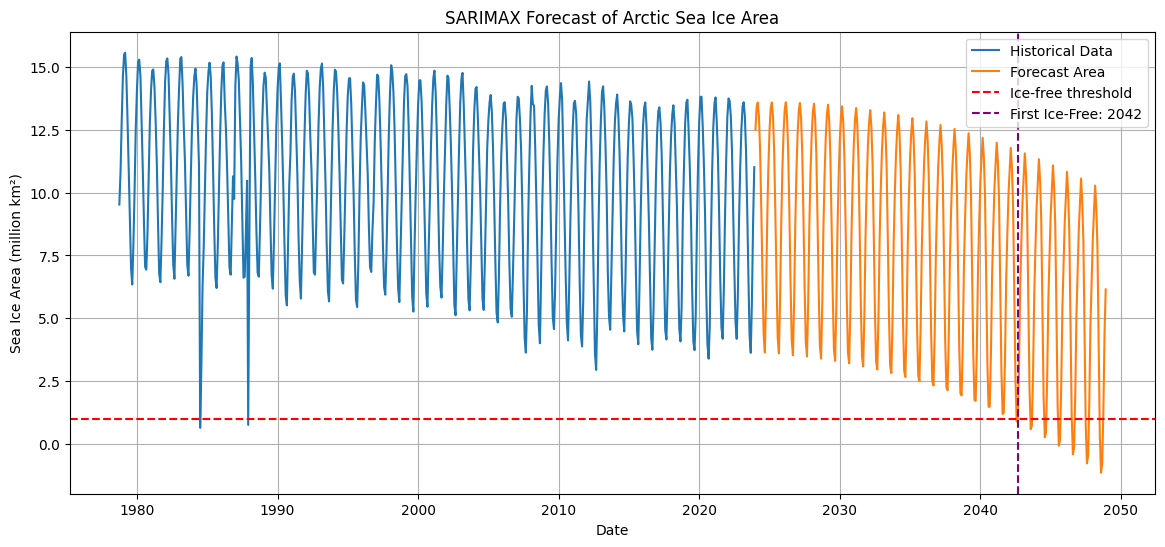

In [15]:
# Plot forecast
plt.figure(figsize=(14, 6))
plt.plot(df["date"].dt.to_timestamp(), y, label="Historical Data")
plt.plot(forecast_df["date"], forecast_df["forecast"], label="Forecast Area")
plt.axhline(1, color="red", linestyle="--", label="Ice-free threshold")

# Add vertical line if ice-free date found
if ice_free_date is not None:
    plt.axvline(x=ice_free_date, color="purple", linestyle="--",
                label=f"First Ice-Free: {ice_free_date.year}")

plt.xlabel("Date")
plt.ylabel("Sea Ice Area (million km²)")
plt.title("SARIMAX Forecast of Arctic Sea Ice Area")
plt.legend(loc="upper right", frameon=True)
plt.grid(True)
plt.show()

This plot shows the forecast of Arctic sea ice extent using a SARIMAX model.  

- **Blue**: Historical satellite observations (1979–2022)  
- **Orange**: Forecast projections (2023–2050)  
- **Red dashed line**: Ice-free threshold (1 million km²)  
- **Purple dashed line**: Predicted first ice-free year - **2042**  

The results suggest that if current trends continue, the Arctic may experience its first ice-free summer around **2042**.  
